# 2.2 Back Transform in polar coordinates

In [12]:
import numpy as np
import matplotlib.pyplot as plt

### Unterpunkt a: Berechnen der F.T. Projektion
Disclaimer: Ich verwende hier die numpy FFT, weil auch für die Reverse FFT die 

numpy funktion verwendet werden soll, sonst ist alles aus Aufgabe 1


In [13]:
# data importieren
data = np.loadtxt('Data/projection.txt', delimiter=',')
p_phi = data
Nphi = data.shape[0] 
Nxi= data.shape[1]

#Intervallle
phi_interval = np.linspace(0, np.pi, Nphi, endpoint=False)  # 0 <= φ < π
ksi_interval = np.linspace(-Nxi/2, Nxi/2, Nxi)
delta_ksi = ksi_interval[1] - ksi_interval[0]

#FFT mit numpy, über die xi Achse, also halt Zeilenweise
freq = np.fft.fftshift(np.fft.fftfreq(Nxi, d=delta_ksi))   #Note to self: fftshift macht 0 in Mitte, fftfreq macht Frequenzachse damit korrekt skaliert
kxi = 2*np.pi * freq 
F_phi_noshift = np.fft.fft(p_phi, axis=1) *delta_ksi   #ungshiftete FFT
F_phi = np.fft.fftshift( np.fft.fft(p_phi, axis=1), axes=1 ) * delta_ksi 
print( F_phi.shape)


(180, 512)


### Unterpunkt b: range of $k_{\xi}$

Um hier den Intervall zu finden verwenden wir Formel bzw Intervall 2.42 aus dem Skript:

#### $\nu_{ny}=\frac{n}{2P}$

wobei n die Abtastpunkte (Spaltenzahl der Projektionsdata) und P die Länge des Messbereichs (Länge ds Intervall von $\xi$)

nun kann man mit k=2pi$\nu$ das gewünschte intervall berechneen, mit hilfe der Niquist Frequenz.

somit folgt 

#### $k_{max}=\frac{\pi n}{\xi_{max}-\xi_{min}}$ und $k_{min}=-\frac{\pi n}{\xi_{max}-\xi_{min}}$

### Unterpunkt c: Modified Projection



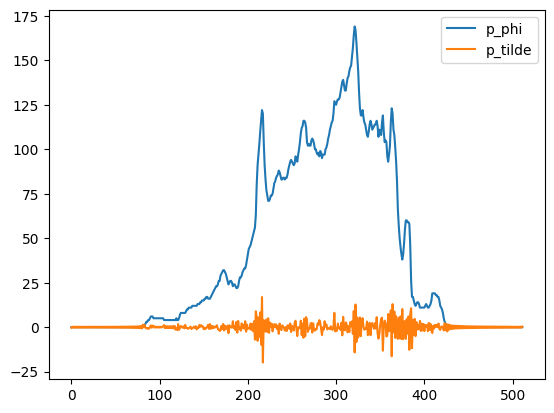

In [17]:
#Mod. Projektion ist die Rücktransformierte FFT * betrag kxi
F_k_mod1 = np.abs(kxi)[None, :] * F_phi_noshift
F_k_mod2= np.abs(kxi)[None, :] * F_phi 
p_tilde = np.fft.ifft(F_k_mod2, axis=1).real

#kurzer Plot als test und sanity chekc lol
plt.plot(p_phi[0], label="p_phi")
plt.plot(p_tilde[0], label="p_tilde")
plt.legend()
#ok schaut schon mal ned schlecht aus, macht auf jeden fall was es soll xD

### Unterpunkt d: Schätzer und Interpolation

In [15]:
# ===== 2.1(d) Interpolation =====

#Gitter machen
K = Nxi
x = np.linspace(ksi_interval[0], ksi_interval[-1], K)
y= np.linspace(ksi_interval[0], ksi_interval[-1], K)

X, Y = np.meshgrid(x, y, indexing="xy")

# Speicher für interpolierte Projektionen:
# Form: [phi, x, y]
p_interp = np.zeros((Nphi, K, K))

# Schleife über alle Winkel φ
for i in range(Nphi):
    phi = phi_interval[i]
    p_tilde_phi = p_tilde[i]

    # ξ' berechnen
    ksi_prime = X*np.cos(phi) + Y*np.sin(phi)

    # Index j finden
    j = np.searchsorted(ksi_interval, ksi_prime) - 1
    j = np.clip(j, 0, Nxi - 2)

    # Lineare Interpolation
    ksi_j = ksi_interval[j]
    ksi_j1 = ksi_interval[j + 1]

    w = (ksi_prime - ksi_j) / (ksi_j1 - ksi_j)
    p_interp[i] = (1-w)*p_tilde_phi[j] + w*p_tilde_phi[j+1]



Text(0, 0.5, "y'")

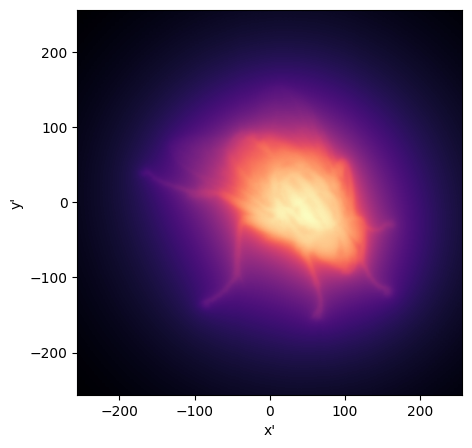

In [22]:
# Winkel-Schrittweite
delta_phi= phi_interval[1] - phi_interval[0]

# Integration über phi laut skript
f_rec = np.sum(p_interp, axis=0) * delta_phi /(2*np.pi) *np.pi/(Nphi+1)

plt.figure(figsize=(5,5))
plt.imshow(
    f_rec,
    extent=[x[0], x[-1], y[0], y[-1]],
    origin="lower",
    cmap="magma" #Fliege glüht! -> Glühwürmchen? 
)
plt.xlabel("x'")
plt.ylabel("y'")